# 영화리뷰 텍스트 감성분석하기

---

## 📋목차

### Import

### 1) 데이터 준비와 확인
네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)

### 2) 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

### 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 4) 모델 구성 및 validation set 구성
- (1) LSTM
- (2) RNN
- (3) GlobalMaxPooling1D

### 5) 모델 훈련 개시

### 6) Loss, Accuracy 그래프 시각화

### 7) 학습된 Embedding 레이어 분석

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
한국어 Word2Vec

- [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)

<!-- #### **참고: [Colab 에 konlpy 와 mecab 설치](https://sanghyu.tistory.com/170)**
```bash
# 1. bash 셀로 명령어를 입력하여 설치
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy
```
```bash
# 2. jdk 환경 변수 설정
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"
```
```bash
# 3. mecab 설치
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996
``` -->

### Import

In [1]:
# Mecab 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-06-07 13:13:58--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-06-07 13:13:58--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbf2e64348ebe067a3db46bf102.dl.dropboxusercontent.com/cd/0/get/BmyRDgojEnJWGviFeLi7F67WpSRzF4oyOunsO_67e9C3mibs_piUuWO8deqiOUMJDEGfguvxqCXGsViaqADH2Ys80IM5SZMSf9KNngKsYXmFau207Vh7WQH7YBTGo7JPmC3QbZ-anCMhwW-ZzHSl1a_Pvmq5l2OPqQXXnrv6Dsm5JZnKeGQJGhxlB6wPXR01nzk/file?dl=1# [following]
--2022-06-07 13:13:58--  https://ucbf2e64348ebe067a3db46bf102.dl.dropboxusercontent.com/cd/0/get

In [2]:
# Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 14.45 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-06-07 13:14:30--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::6b17:d1f5, 2406:da00:ff00::22c0:3470, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://b

In [3]:
import pandas as pd

from konlpy.tag import Okt, Mecab
import numpy as np
from collections import Counter

import tensorflow as tf
import os

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

from keras.callbacks import EarlyStopping, ModelCheckpoint

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1) 데이터 준비와 확인

In [4]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/코드 및 데이터파일/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/코드 및 데이터파일/ratings_test.txt')

train_data.tail()

,id,document,label
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


**데이터 확인**  
label 0: 부정적 document  
label 1: 긍정적 document

### 2) 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

노드에서는 Mecab을 사용했지만, 여러 분석기에 관해 궁금증이 생겨 찾아보았다.  
결과적으로, Mecab이 돋보적인 속도를 내며 성능도 우수한 편이란 걸 확인하여 변경 없이 사용했다.  
[한국어 형태소 분석기 성능비교](https://iostream.tistory.com/144)

In [109]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
  # 데이터 중복 제거, 결측치 제거
  train_data.drop_duplicates(subset=['document'], inplace=True)  
  train_data = train_data.dropna(how = 'any')  
  test_data.drop_duplicates(subset=['document'], inplace=True)  
  test_data = test_data.dropna(how = 'any')  

  # train 데이터 토큰화, 불용어 제거
  X_train = []
  for sentence in train_data['document']:
      temp_X = tokenizer.morphs(sentence) 
      temp_X = [word for word in temp_X if not word in stopwords] 
      X_train.append(temp_X) 

  # test 데이터 토큰화, 불용어 제거
  X_test = []
  for sentence in test_data['document']:
      temp_X = tokenizer.morphs(sentence) 
      temp_X = [word for word in temp_X if not word in stopwords] 
      X_test.append(temp_X) 
  
  # 병합 및 list 변환, {단어: 인덱스} 형태의 딕셔너리 word_to_index 생성
  words = np.concatenate(X_train).tolist()  
  counter = Counter(words)  
  counter = counter.most_common(10000-4)
  vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] 
  word_to_index = {word:index for index, word in enumerate(vocab)} 
  
  def wordlist_to_indexlist(wordlist):
      return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
      
  # 리스트 요소를 함수 처리 후 리스트로 반환
  X_train = list(map(wordlist_to_indexlist, X_train))
  X_test = list(map(wordlist_to_indexlist, X_test))
      
  return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
len(word_to_index)

10000

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [9]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape) 
print(X_test.shape)  

(146182, 41)
(49157, 41)


- **Q. padding 에서 post가 아닌 pre를 선택한 이유?**  
RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됩니다.  
그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적입니다.  
따라서 **'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이**를 보이게 됩니다.

### 4) 모델 구성 및 validation set 구성

In [12]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기: 10000개 단어
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. (변경 가능한 하이퍼 파라미터)

### (1) LSTM

In [13]:
LSTM = tf.keras.Sequential()
LSTM.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
LSTM.add(tf.keras.layers.Dense(8, activation='relu'))
LSTM.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


### (2) 1-D Convolution Neural Network(CNN)

In [14]:
CNN = tf.keras.Sequential()
CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN.add(tf.keras.layers.MaxPooling1D(5))
CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN.add(tf.keras.layers.GlobalMaxPooling1D())
CNN.add(tf.keras.layers.Dense(8, activation='relu'))
CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         2000000   
                                                                 
 conv1d (Conv1D)             (None, None, 16)          22416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

### (3) GlobalMaxPooling1D

In [15]:
Globalmp = tf.keras.Sequential()
Globalmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
Globalmp.add(tf.keras.layers.GlobalMaxPooling1D())
Globalmp.add(tf.keras.layers.Dense(8, activation='relu'))
Globalmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

Globalmp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 200)         2000000   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 1608      
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [16]:
# validation set 30000개 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# 그 외 나머지 데이터
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(x_val.shape)  
print(y_val.shape) 

print(partial_x_train.shape) 
print(partial_y_train.shape)  

(30000, 41)
(30000,)
(116182, 41)
(116182,)


In [17]:
# early_stopping 설정, patience=5
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

(1) LSTM

In [18]:
LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = LSTM.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/5
227/227 [==============================] - 5s 10ms/step - loss: 0.4540 - accuracy: 0.8026 - val_loss: 0.3525 - val_accuracy: 0.8504
Epoch 2/5
227/227 [==============================] - 2s 8ms/step - loss: 0.3265 - accuracy: 0.8626 - val_loss: 0.3401 - val_accuracy: 0.8525
Epoch 3/5
227/227 [==============================] - 2s 8ms/step - loss: 0.2977 - accuracy: 0.8750 - val_loss: 0.3414 - val_accuracy: 0.8517
Epoch 4/5
227/227 [==============================] - 2s 8ms/step - loss: 0.2759 - accuracy: 0.8857 - val_loss: 0.3473 - val_accuracy: 0.8536
Epoch 5/5
227/227 [==============================] - 2s 8ms/step - loss: 0.2563 - accuracy: 0.8948 - val_loss: 0.3605 - val_accuracy: 0.8511


In [19]:
# 모델 평가
results_lstm = LSTM.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_lstm) 

1537/1537 - 3s - loss: 0.3704 - accuracy: 0.8459 - 3s/epoch - 2ms/step
[0.3703700304031372, 0.8458815813064575]


(2) CNN

In [20]:
CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_CNN = CNN.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/5
227/227 [==============================] - 3s 9ms/step - loss: 0.4419 - accuracy: 0.7878 - val_loss: 0.3444 - val_accuracy: 0.8495
Epoch 2/5
227/227 [==============================] - 2s 8ms/step - loss: 0.2999 - accuracy: 0.8753 - val_loss: 0.3296 - val_accuracy: 0.8578
Epoch 3/5
227/227 [==============================] - 2s 7ms/step - loss: 0.2366 - accuracy: 0.9067 - val_loss: 0.3448 - val_accuracy: 0.8543
Epoch 4/5
227/227 [==============================] - 2s 7ms/step - loss: 0.1659 - accuracy: 0.9393 - val_loss: 0.3909 - val_accuracy: 0.8529
Epoch 5/5
227/227 [==============================] - 2s 7ms/step - loss: 0.1038 - accuracy: 0.9649 - val_loss: 0.4554 - val_accuracy: 0.8475


In [21]:
# 모델 평가
results_CNN = CNN.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_CNN)

1537/1537 - 3s - loss: 0.4732 - accuracy: 0.8442 - 3s/epoch - 2ms/step
[0.47321459650993347, 0.8441931009292603]


(3) GlobalMaxPooling1D

In [22]:
Globalmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_Globalmp = Globalmp.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/5
227/227 [==============================] - 2s 7ms/step - loss: 0.5423 - accuracy: 0.7478 - val_loss: 0.3822 - val_accuracy: 0.8412
Epoch 2/5
227/227 [==============================] - 1s 6ms/step - loss: 0.3331 - accuracy: 0.8613 - val_loss: 0.3359 - val_accuracy: 0.8544
Epoch 3/5
227/227 [==============================] - 1s 6ms/step - loss: 0.2796 - accuracy: 0.8867 - val_loss: 0.3368 - val_accuracy: 0.8556
Epoch 4/5
227/227 [==============================] - 1s 6ms/step - loss: 0.2393 - accuracy: 0.9066 - val_loss: 0.3457 - val_accuracy: 0.8557
Epoch 5/5
227/227 [==============================] - 1s 6ms/step - loss: 0.2000 - accuracy: 0.9247 - val_loss: 0.3651 - val_accuracy: 0.8535


In [23]:
# 모델 평가
results_Globalmp =Globalmp.evaluate(X_test,  y_test, verbose=2)  # (loss, accuracy)

print(results_Globalmp) 

1537/1537 - 2s - loss: 0.3771 - accuracy: 0.8491 - 2s/epoch - 1ms/step
[0.3771449625492096, 0.8490550518035889]


**훈련결과**  

|Num|Model|Loss|Accuracy|
|:---:|:---:|:---:|:---:|
|1|LSTM|0.3704|0.8459|
|2|CNN|0.4732|0.8442|
|3|GlobalMaxPooling1D|0.3771|0.8491|

LSTM이 전체적으로 가장 우수한 걸 알 수 있음

### 6) Loss, Accuracy 그래프 시각화

(1) LSTM

In [24]:
history_dict = history_lstm.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

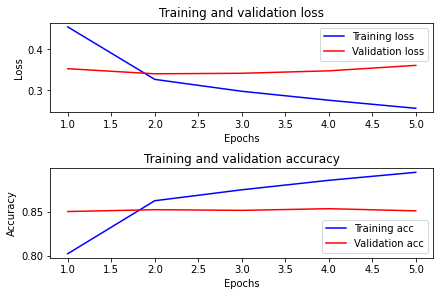

In [26]:
# plt.subplots
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Training and Validation Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

(2) CNN

In [27]:
history_dict = history_CNN.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [28]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

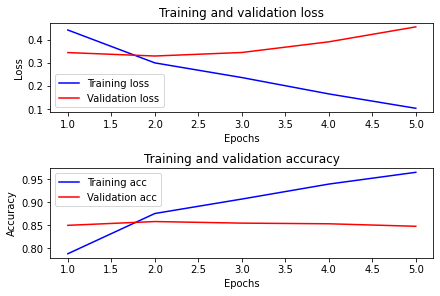

In [29]:
# plt.subplots
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Training and Validation Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

(3) GloablMaxPooling1D()  레이어 1개만 사용

In [30]:
history_dict = history_Globalmp.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [31]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

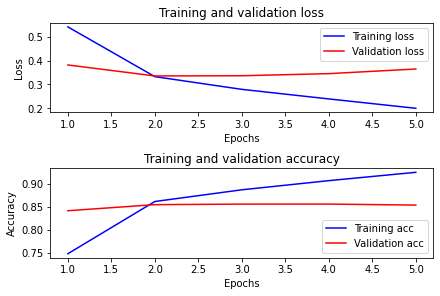

In [32]:
# plt.subplots
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Training and Validation Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

### 7) 학습된 Embedding 레이어 분석

In [33]:
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors

(1) LSTM

In [34]:
embedding_layer = LSTM.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [35]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/코드 및 데이터파일/word2vec_LSTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([ 0.15237606,  0.0473455 ,  0.0799642 ,  0.00126778, -0.01310756,
       -0.00862263, -0.11485208,  0.04370354,  0.01954538,  0.07097904,
        0.05789285,  0.04336971, -0.06620966, -0.07407186,  0.00801546,
        0.05577038, -0.04650631,  0.04861246,  0.05166094,  0.04937296,
       -0.00882916,  0.06395892, -0.01844234, -0.01960909,  0.00929656,
       -0.06443128,  0.04304203, -0.11596642,  0.07970174, -0.08148592,
        0.03799149, -0.03812835, -0.03408949,  0.09252037,  0.11875434,
        0.02737379,  0.08776987, -0.03178622,  0.04820187,  0.1163798 ,
       -0.073465  , -0.0659675 ,  0.04004329,  0.07649262, -0.10669417,
        0.1003745 ,  0.17399542, -0.09095766, -0.08041388,  0.05613911,
        0.0549667 ,  0.1200193 , -0.10170417, -0.05206016, -0.07519055,
        0.0309456 ,  0.00949498,  0.05624068, -0.06109161, -0.11028753,
        0.07904989,  0.04261084,  0.0462501 , -0.01708616, -0.07081743,
       -0.08198313, -0.00728039,  0.05390731,  0.07315324, -0.11

In [37]:
# 단어를 직접 입력하여 유사도 확인
word_vectors.similar_by_word("감동")

[('치유', 0.8120667338371277),
 ('어울려요', 0.8073513507843018),
 ('짱', 0.8037900924682617),
 ('me', 0.796414852142334),
 ('두근두근', 0.7841657996177673),
 ('이뻐요', 0.7835958003997803),
 ('예뻐', 0.7807248830795288),
 ('리얼', 0.7800997495651245),
 ('습니당', 0.7786869406700134),
 ('으뜸', 0.7783225774765015)]

In [38]:
word_vectors.similar_by_word("재미")

[('가치', 0.7453298568725586),
 ('너무나', 0.6742794513702393),
 ('긴장감', 0.6742029786109924),
 ('거의', 0.669752836227417),
 ('겁나', 0.6617737412452698),
 ('완전', 0.6571458578109741),
 ('너무', 0.6519266963005066),
 ('이렇게', 0.6516557931900024),
 ('노튼', 0.6466535329818726),
 ('명배우', 0.6462835669517517)]

In [39]:
word_vectors.similar_by_word("식상")

[('반개', 0.9378017783164978),
 ('포장', 0.9357354640960693),
 ('엉성', 0.935283899307251),
 ('낚였', 0.9336525797843933),
 ('유치찬란', 0.9326907396316528),
 ('개뿔', 0.9305771589279175),
 ('하품', 0.9303525686264038),
 ('광구', 0.9296461343765259),
 ('낭비', 0.9285019040107727),
 ('짝퉁', 0.9276681542396545)]

In [40]:
word_vectors.similar_by_word("대박")

[('명불허전', 0.8628463745117188),
 ('최고', 0.8614717721939087),
 ('진하', 0.8598839044570923),
 ('짠', 0.8597712516784668),
 ('원본', 0.8541133403778076),
 ('짱짱', 0.8539385795593262),
 ('안다', 0.8538383841514587),
 ('아름다웠', 0.8535431623458862),
 ('검색어', 0.8534026145935059),
 ('해학', 0.8533707857131958)]

In [41]:
word_vectors.similar_by_word("최악")

[('개콘', 0.9300809502601624),
 ('먹칠', 0.9144563674926758),
 ('불면증', 0.9138725996017456),
 ('거려', 0.9136247634887695),
 ('류영화', 0.913260817527771),
 ('낭비', 0.9114535450935364),
 ('낚였', 0.9109793901443481),
 ('조악', 0.9101647734642029),
 ('난감', 0.9095876216888428),
 ('하품', 0.9088411331176758)]

In [42]:
word_vectors.similar_by_word("수작")

[('손색', 0.9503485560417175),
 ('이만', 0.9493443965911865),
 ('울컥', 0.9482425451278687),
 ('뗄', 0.9476726055145264),
 ('담백', 0.9451713562011719),
 ('흠잡', 0.9447801113128662),
 ('나무랄', 0.9430028200149536),
 ('빠져드', 0.9423211812973022),
 ('각지', 0.9413110017776489),
 ('올려야', 0.9393706917762756)]

(2) CNN

In [43]:
embedding_layer = CNN.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [44]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/코드 및 데이터파일/word2vec_CNN.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = CNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [45]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([ 0.03772516,  0.06321974, -0.0747199 ,  0.01498834, -0.00864781,
       -0.0789374 , -0.00291768, -0.04299149,  0.07408161, -0.00031777,
        0.03327503,  0.06283321, -0.05306966,  0.05579181, -0.06790805,
        0.1804614 , -0.09821264,  0.02118816,  0.01640191,  0.07490108,
        0.00440446, -0.14736316,  0.06658617, -0.08972482, -0.01251635,
        0.08617476,  0.05648052, -0.06939581, -0.03537386,  0.05373881,
       -0.04316508, -0.06744466,  0.01805308,  0.06322719,  0.08657517,
       -0.03093389, -0.04592578, -0.06173767,  0.05812583, -0.0359369 ,
        0.00916613,  0.03326654,  0.01190363,  0.03652972, -0.00376959,
       -0.06097046,  0.0941769 ,  0.04758231, -0.06129489,  0.04846021,
       -0.07567263,  0.0562485 ,  0.07303167, -0.16552602,  0.02198701,
        0.00488904, -0.00817297,  0.07097809, -0.05975241,  0.05165193,
       -0.05778364,  0.02208432,  0.13140352, -0.04610149,  0.01170409,
       -0.07759446, -0.03379145, -0.07659688, -0.04718324,  0.00

In [46]:
# 단어를 직접 입력하여 유사도 확인
word_vectors.similar_by_word("감동")

[('차가운', 0.6493548154830933),
 ('로라', 0.6381090879440308),
 ('이제서야', 0.6288696527481079),
 ('이창동', 0.627718448638916),
 ('슬퍼요', 0.626189112663269),
 ('love', 0.6216421127319336),
 ('눈물나', 0.6191648840904236),
 ('브금', 0.6180635690689087),
 ('탱고', 0.617479681968689),
 ('막힌다', 0.6164385080337524)]

In [47]:
word_vectors.similar_by_word("재미")

[('겁내', 0.4948475658893585),
 ('취향', 0.49448099732398987),
 ('송', 0.4930404722690582),
 ('긴장감', 0.48170265555381775),
 ('넘어서', 0.478853702545166),
 ('앤더슨', 0.4569656252861023),
 ('강동원', 0.4500468969345093),
 ('젼', 0.44678089022636414),
 ('열라', 0.44627100229263306),
 ('완전', 0.4455503225326538)]

In [48]:
word_vectors.similar_by_word("식상")

[('이따위', 0.8242850303649902),
 ('베끼', 0.7984167337417603),
 ('자질', 0.7961310148239136),
 ('아까움', 0.7948204874992371),
 ('각본가', 0.7937673926353455),
 ('조악', 0.792833685874939),
 ('낮춰야', 0.7920374870300293),
 ('류영화', 0.7834780812263489),
 ('맞출', 0.7830004692077637),
 ('개뿔', 0.7817846536636353)]

In [49]:
word_vectors.similar_by_word("대박")

[('담백', 0.7303814888000488),
 ('개꿀', 0.716156005859375),
 ('펑펑', 0.7084262371063232),
 ('이만', 0.6953769326210022),
 ('탁월', 0.6839461326599121),
 ('예쁨', 0.6825318932533264),
 ('서늘', 0.681158185005188),
 ('Good', 0.6798067688941956),
 ('흠뻑', 0.6766649484634399),
 ('빨려', 0.6753531694412231)]

In [50]:
word_vectors.similar_by_word("최악")

[('조악', 0.8843213319778442),
 ('개그맨', 0.8779024481773376),
 ('불면증', 0.8699727058410645),
 ('하품', 0.8681690692901611),
 ('최저', 0.8641805052757263),
 ('낭비', 0.8616355657577515),
 ('이따위', 0.8608605861663818),
 ('지겨워', 0.8565430641174316),
 ('후레쉬', 0.8556440472602844),
 ('서세원', 0.851409375667572)]

In [51]:
word_vectors.similar_by_word("수작")

[('울컥', 0.8337222337722778),
 ('넘사벽', 0.8307821750640869),
 ('빠져드', 0.8206984996795654),
 ('탁월', 0.8192213773727417),
 ('새록새록', 0.819133996963501),
 ('진진', 0.8058735132217407),
 ('완소', 0.8039824962615967),
 ('슬퍼요', 0.8033144474029541),
 ('고마워요', 0.8002432584762573),
 ('예뻐요', 0.7994992136955261)]

(3) GlobalMaxPooling1D

In [52]:
embedding_layer = Globalmp.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [53]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/코드 및 데이터파일/word2vec_Globalmp.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = Globalmp.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [54]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['감동']
vector

array([-0.0401709 ,  0.19943035,  0.00848636, -0.09537043, -0.07410424,
       -0.06486712, -0.01878466, -0.04001248, -0.07148954,  0.12455983,
       -0.02102704, -0.04887458, -0.09311292, -0.08451802, -0.01095361,
        0.0234554 , -0.0627197 , -0.0666571 ,  0.0045432 , -0.04553796,
       -0.06950657, -0.07356788, -0.07076095, -0.07501304,  0.08453305,
       -0.09601703, -0.07898164, -0.04639165, -0.04072146, -0.01555482,
       -0.07911054, -0.06801441, -0.09828065, -0.07475761,  0.14795808,
       -0.10640394,  0.10434572, -0.08661377,  0.13530348, -0.03287092,
       -0.04485635, -0.04259911, -0.09093101, -0.01988632, -0.0893528 ,
       -0.07769618, -0.07907114, -0.0779094 ,  0.08606071, -0.09164531,
       -0.06427467,  0.05059019,  0.08817092, -0.04629711,  0.08057401,
       -0.0745654 , -0.07201511,  0.04698185,  0.02429114, -0.06265641,
       -0.06314176,  0.0851109 , -0.03444915, -0.08128088, -0.06602054,
        0.12384667,  0.10785973, -0.04560191, -0.0705653 , -0.10

In [55]:
# 단어를 직접 입력하여 유사도 확인
word_vectors.similar_by_word("감동")

[('스릴', 0.5887953042984009),
 ('매우', 0.5284307599067688),
 ('ㅣ', 0.5222504138946533),
 ('슬퍼', 0.5219835638999939),
 ('반전', 0.49852409958839417),
 ('아하', 0.49526286125183105),
 ('어울렸', 0.49498412013053894),
 ('연기', 0.49398088455200195),
 ('로맨스', 0.4937978684902191),
 ('무서움', 0.4907195568084717)]

In [56]:
word_vectors.similar_by_word("재미")

[('감동', 0.38425201177597046),
 ('스릴', 0.3791712522506714),
 ('가치', 0.3714750409126282),
 ('민간인', 0.370341956615448),
 ('잼', 0.3596760034561157),
 ('긴장감', 0.3354104161262512),
 ('아무런', 0.3234223425388336),
 ('전후', 0.31574955582618713),
 ('젬', 0.311912477016449),
 ('총알', 0.30694863200187683)]

In [57]:
word_vectors.similar_by_word("식상")

[('별루', 0.5187641382217407),
 ('싸구려', 0.5048596858978271),
 ('개똥', 0.5009546279907227),
 ('수면제', 0.48543643951416016),
 ('지겹', 0.47590935230255127),
 ('망', 0.47353169322013855),
 ('개뿔', 0.471548855304718),
 ('라구', 0.46642550826072693),
 ('아까움', 0.46222203969955444),
 ('중구난방', 0.4615148901939392)]

In [58]:
word_vectors.similar_by_word("대박")

[('감탄', 0.33513087034225464),
 ('질투', 0.3324732780456543),
 ('디스', 0.3229908347129822),
 ('달달', 0.32092615962028503),
 ('나와도', 0.3206024169921875),
 ('예뻐', 0.3177111744880676),
 ('2009', 0.3127956986427307),
 ('재이', 0.30260491371154785),
 ('on', 0.29939016699790955),
 ('GOOD', 0.2975025177001953)]

In [59]:
word_vectors.similar_by_word("최악")

[('쓰레기', 0.6063394546508789),
 ('아까움', 0.5719739198684692),
 ('하품', 0.5688925981521606),
 ('짝퉁', 0.5202991366386414),
 ('개뿔', 0.5071796178817749),
 ('글쎄요', 0.5058823823928833),
 ('낚였', 0.4997100532054901),
 ('ㅗ', 0.4991428256034851),
 ('boring', 0.4956667721271515),
 ('조잡', 0.49427661299705505)]

In [60]:
word_vectors.similar_by_word("수작")

[('여운', 0.5277731418609619),
 ('쪼', 0.5158436894416809),
 ('봉준호', 0.5128100514411926),
 ('완소', 0.5071408748626709),
 ('조아', 0.5050942301750183),
 ('묵직', 0.5050868988037109),
 ('똥파리', 0.5026242733001709),
 ('Good', 0.5024047493934631),
 ('펑펑', 0.5019084215164185),
 ('GOOD', 0.5012533664703369)]

- **Embedding 레이어 분석**  
세 모델 전부 투입 단어와 유사한 단어를 찾아냈으나, 단편적으로 확인해도 LTSM이 가장 유사도가 높은 단어를 찾아내는것을 확인했다.  
단어가 가진 긍/부정의 모호성이 없을 수록 유사도가 더 높은 단어를 찾아내는 것으로 추정된다.  
ex) 최악, 수작 전부 LSTM 모델 내에서 0.9 이상의 유사도를 보이는 단어를 찾아냄

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

#### 1) LSTM
가장 성능이 좋은 모델로 판단되는 LSTM으로 성능 개선을 시도

In [61]:
!pip install --upgrade gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
import gensim
from gensim.models import KeyedVectors

In [63]:
word2vec_path = '/content/drive/MyDrive/Colab Notebooks/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

print(word2vec.wv.vectors.shape)

vector = word2vec.wv.most_similar("감동") 
vector    

(30185, 200)


[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [64]:
vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [65]:
from tensorflow.keras.initializers import Constant

(1) LSTM

In [66]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                67840     
                                                                 
 dense_6 (Dense)             (None, 256)               16640     
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,084,737
Trainable params: 2,084,737
Non-trainable params: 0
_________________________________________________________________


In [67]:
# 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/5
3631/3631 [==============================] - 28s 7ms/step - loss: 0.3896 - accuracy: 0.8221 - val_loss: 0.3231 - val_accuracy: 0.8591
Epoch 2/5
3631/3631 [==============================] - 21s 6ms/step - loss: 0.2939 - accuracy: 0.8751 - val_loss: 0.3185 - val_accuracy: 0.8646
Epoch 3/5
3631/3631 [==============================] - 21s 6ms/step - loss: 0.2523 - accuracy: 0.8959 - val_loss: 0.3233 - val_accuracy: 0.8640
Epoch 4/5
3631/3631 [==============================] - 21s 6ms/step - loss: 0.2138 - accuracy: 0.9136 - val_loss: 0.3314 - val_accuracy: 0.8663
Epoch 5/5
3631/3631 [==============================] - 22s 6ms/step - loss: 0.1775 - accuracy: 0.9297 - val_loss: 0.3688 - val_accuracy: 0.8634


In [68]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results) 

1537/1537 - 3s - loss: 0.3693 - accuracy: 0.8579 - 3s/epoch - 2ms/step
[0.36926642060279846, 0.8578839302062988]


In [69]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [70]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

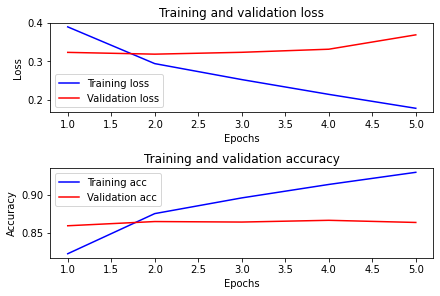

In [71]:
# plt.subplots
fig, axs = plt.subplots(2 ,1, constrained_layout=True)

# Loss 그래프
axs[0].plot(epochs, loss, 'b', label='Training loss')
axs[0].plot(epochs, val_loss, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Accuracy 그래프
axs[1].plot(epochs, acc, 'b', label='Training acc')
axs[1].plot(epochs, val_acc, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


plt.show()

In [72]:
word_vectors.similar_by_word("감동")

[('스릴', 0.5887953042984009),
 ('매우', 0.5284307599067688),
 ('ㅣ', 0.5222504138946533),
 ('슬퍼', 0.5219835638999939),
 ('반전', 0.49852409958839417),
 ('아하', 0.49526286125183105),
 ('어울렸', 0.49498412013053894),
 ('연기', 0.49398088455200195),
 ('로맨스', 0.4937978684902191),
 ('무서움', 0.4907195568084717)]

In [73]:
word_vectors.similar_by_word("재미")

[('감동', 0.38425201177597046),
 ('스릴', 0.3791712522506714),
 ('가치', 0.3714750409126282),
 ('민간인', 0.370341956615448),
 ('잼', 0.3596760034561157),
 ('긴장감', 0.3354104161262512),
 ('아무런', 0.3234223425388336),
 ('전후', 0.31574955582618713),
 ('젬', 0.311912477016449),
 ('총알', 0.30694863200187683)]

In [74]:
word_vectors.similar_by_word("식상")

[('별루', 0.5187641382217407),
 ('싸구려', 0.5048596858978271),
 ('개똥', 0.5009546279907227),
 ('수면제', 0.48543643951416016),
 ('지겹', 0.47590935230255127),
 ('망', 0.47353169322013855),
 ('개뿔', 0.471548855304718),
 ('라구', 0.46642550826072693),
 ('아까움', 0.46222203969955444),
 ('중구난방', 0.4615148901939392)]

In [75]:
word_vectors.similar_by_word("대박")

[('감탄', 0.33513087034225464),
 ('질투', 0.3324732780456543),
 ('디스', 0.3229908347129822),
 ('달달', 0.32092615962028503),
 ('나와도', 0.3206024169921875),
 ('예뻐', 0.3177111744880676),
 ('2009', 0.3127956986427307),
 ('재이', 0.30260491371154785),
 ('on', 0.29939016699790955),
 ('GOOD', 0.2975025177001953)]

In [76]:
word_vectors.similar_by_word("최악")

[('쓰레기', 0.6063394546508789),
 ('아까움', 0.5719739198684692),
 ('하품', 0.5688925981521606),
 ('짝퉁', 0.5202991366386414),
 ('개뿔', 0.5071796178817749),
 ('글쎄요', 0.5058823823928833),
 ('낚였', 0.4997100532054901),
 ('ㅗ', 0.4991428256034851),
 ('boring', 0.4956667721271515),
 ('조잡', 0.49427661299705505)]

In [77]:
word_vectors.similar_by_word("수작")

[('여운', 0.5277731418609619),
 ('쪼', 0.5158436894416809),
 ('봉준호', 0.5128100514411926),
 ('완소', 0.5071408748626709),
 ('조아', 0.5050942301750183),
 ('묵직', 0.5050868988037109),
 ('똥파리', 0.5026242733001709),
 ('Good', 0.5024047493934631),
 ('펑펑', 0.5019084215164185),
 ('GOOD', 0.5012533664703369)]

**결과분석**  

|Num|Model|Loss|Accuracy|
|:---:|:---:|:---:|:---:|
|1|LSTM|0.3704|0.8459|
|2|개선 LSTM|0.3693|0.8579|

  
결과적으로, 개선 LSTM의 정확도가 올라가고,  
Loss가 줄어든 것을 확인할 수 있다.

### 리뷰 긍정 / 부정 예측해보기 (실패)

In [158]:
import re
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
okt = Okt()

In [170]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 100)         1000000   
                                                                 
 lstm_8 (LSTM)               (None, 128)               117248    
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [164]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/5
3631/3631 [==============================] - 23s 6ms/step - loss: 0.3816 - acc: 0.8292 - val_loss: 0.3437 - val_acc: 0.8488
Epoch 2/5
3631/3631 [==============================] - 21s 6ms/step - loss: 0.3148 - acc: 0.8658 - val_loss: 0.3211 - val_acc: 0.8604
Epoch 3/5
3631/3631 [==============================] - 21s 6ms/step - loss: 0.2926 - acc: 0.8776 - val_loss: 0.3065 - val_acc: 0.8689
Epoch 4/5
3631/3631 [==============================] - 21s 6ms/step - loss: 0.2772 - acc: 0.8856 - val_loss: 0.3032 - val_acc: 0.8704
Epoch 5/5
3631/3631 [==============================] - 21s 6ms/step - loss: 0.2639 - acc: 0.8924 - val_loss: 0.2962 - val_acc: 0.8736


In [171]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = maxlen) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [172]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

50.55% 확률로 긍정 리뷰입니다.



In [173]:
sentiment_predict('재미없어')

50.55% 확률로 긍정 리뷰입니다.



In [155]:
sentiment_predict('진짜 재밌다')

50.62% 확률로 긍정 리뷰입니다.



In [161]:
sentiment_predict('개노잼이다 진짜')

50.04% 확률로 긍정 리뷰입니다.



망했지만 넣어보았다.

# Summary

### 힘들었던 점
- 활용 라이브러리가 많아질 수록, 불러오기가 까다로워지는 거 같다. 다행히 해결법을 찾았지만, 시작부터 안되는 경우 난감함을 느낀다.
- NLP의 핵심은 확실히 전처리라고 생각한다. 할 때마다 정신이 없게 느껴지는데, 언젠가는 익숙해질 날이 있지 않을까?  

### 아쉬웠던 점
- 논문을 찾다보니 [CNN-LSTM 조합모델을 이용한 영화리뷰 감성분석](https://www.koreascience.or.kr/article/JAKO201909358629867.pdf)을 발견하였다.  
CNN-LSTM 조합이 다른 모델들에 비해 정확도가 높다는 내용이었는데, 해당 내용으로 모델을 직접 설계하다가 계속 오류가 나서 빼버렸다.  
데이터톤 이후 시간을 가지고 보려던 계획에 또 차질이 생겼다. 시간 날 때 다시 볼 예정.
- 코드를 이해하는데 오랜시간이 걸려, 백지 코딩을 해보려고 했으나 도저히 불가했다. NLP를 선택한 이상 피할 수 없는 길이 될텐데, 좀 더 열심히 해야겠다는 생각이 들었다.
- 리뷰 긍정/부정 예측을 넣어보려고 시도했으나, 실패했다. 예측기의 토크나이저가 Okt 기반으로 되어있어, mecab 기반 문법으로 고치다가 고장났다.  
그래서 아예 새롭게 Okt 기반의 모델을 만들어서 활용하려고 했는데, 결국 다 틀린 예측을 하는 예측기가 탄생했다.  
제출 전까지 뜯어봤으나, 실패했다 다음에 다시 도전할 예정!